Demonstrate functions that calculate Nyquist zone and aliased frequency

In [1]:
import importlib
from mkids import TopSoc
import numpy as np
import matplotlib.pyplot as plt
import Scan
import pickle
soc = TopSoc(force_init_clks=False)

In [3]:
print("ADCs ", soc.adcs)
print("DACs ", soc.dacs)

ADCs  {'20': {'fs': 2457.6, 'f_fabric': 307.2}}
DACs  {'20': {'fs': 4915.2, 'f_fabric': 307.2}}


Text(0.5, 0, 'Tone Frequency')

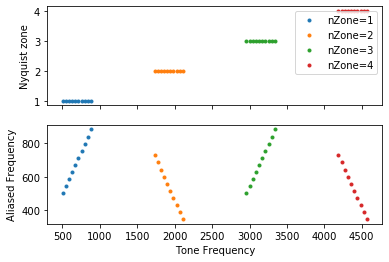

In [23]:
fNyquist = soc.fsIn/2

fig,ax = plt.subplots(2,1,sharex=True)
for nZone in [1,2,3,4]:
    fMixer = 500 + (nZone-1)*fNyquist
    fMixerSet = soc.set_mixer(fMixer)
    fTone = fMixer + 1.123
    fTones = fTone + 42.3*np.arange(10)
    nZones = soc.nZoneFromFTone(fTones)
    assert nZone == nZones.mean()
    fAliased = soc.fAliasedFromFTone(fTones)
    
    ax[0].plot(fTones, nZones, ".",label="nZone=%d"%nZone)
    ax[1].plot(fTones, fAliased, ".",label=nZone)
ax[0].legend()
ax[0].set_ylabel("Nyquist zone")
ax[1].set_ylabel("Aliased Frequency")
ax[1].set_xlabel("Tone Frequency")
    